In [923]:
import numpy as np
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel
import cv2
import time
import timeit

In [924]:
st = time.time()
class GaborDescriptor:
	def __init__(self,params):
		#Class Constructor
		self.theta = params['theta']
		self.frequency = params['frequency']
		self.sigma = params['sigma']
		self.n_slice = params['n_slice']

	# a fucntion that return a list of gabor kernels
	def kernels(self):
		kernels = []
		for theta in range(self.theta):
			theta = theta/4. * np.pi
			for frequency in self.frequency:
				for sigma in self.sigma:
					kernel = gabor_kernel(frequency,theta=theta,sigma_x=sigma,sigma_y=sigma)
					kernels.append(kernel)
		return kernels


	def gaborHistogram(self,image,gabor_kernels):
		#extracting the Image height ,widht and the number of colors
		height,width,channel = image.shape

		"""deviding the image into four parts ,applying on each part the _gabor() : (64 ,) 
        [because we flattened 32 gabor filter with the maean and variance ],
		also storing the results in the hist variable:numpy.ndarray with the shape of (2, 2, 64) 
        becuase the (64 ,) distrubuted on a squares as follows :
		[0][0] ,[0][1] ,[1][0] ,[1][1].
		Finnaly devieding each cube value on the total values , 
        and returning the flattened shape of the hist variable as (256,)
		"""
		hist = np.zeros((self.n_slice,self.n_slice,2*len(gabor_kernels))) #2*len because we need to store both the mean and the variance
		h_silce = np.around(np.linspace(0, height, self.n_slice+1, endpoint=True)).astype(int)
		w_slice = np.around(np.linspace(0, width, self.n_slice+1, endpoint=True)).astype(int)
		for hs in range(len(h_silce)-1):
			for ws in range(len(w_slice)-1):
				img_r = image[h_silce[hs]:h_silce[hs+1], w_slice[ws]:w_slice[ws+1]]  # slice img to regions
				#from matplotlib import pyplot as plt
				#plt.imshow(img_r, interpolation='nearest')
				#plt.show()
				hist[hs][ws] = self._gabor(img_r,gabor_kernels)

		hist /= np.sum(hist)
		return hist.flatten()

	def _power(self,image,kernel):
		image = (image - image.mean()) / image.std()
		f_img = np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 + ndi.convolve(image, np.imag(kernel), mode='wrap')**2)
		feats = np.zeros(2, dtype=np.double)
		feats[0] = f_img.mean()
		feats[1] = f_img.var()
		return feats

	def _gabor(self,image,gabor_kernels):
		#converting image to COLOR_BGR2GRAY color space
		gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
		results = []
		#for each kernel in the 32 gabor kernels
		for kernel in gabor_kernels:
			#extracting the mean and variance
			results.append(self._power(gray_img,kernel))

		hist = np.array(results)
		# hist.shape -> (2 , 32) [mean and variance for 32 gabor kernel]
		hist = hist / np.sum(hist, axis=0)
		"""returning the flattend transpose of numpy.ndarray:(2, 32) after devidied every value by of the sum of each row in the hist 
		variable ,the shape of the return is (64,) for each part of the query image
		"""
		return hist.T.flatten() # .T -> transpose && shape == (2 , 32)

In [925]:
import csv

params = {"theta": 4, "frequency": (0, 1, 0.5, 0.8), "sigma": (1, 3), "n_slice": 2}

class Search:
    def __init__(self, path):
        #the cvs file's path
        self.path = path
    
    def search(self, queryFeatures, limit=50):
        results = dict()
        #results.popitem()
        #print("popitem -> ",results)
        #results.clear()
        #m =-1
        #opening the csv file
        with open(self.path) as f:
            reader = csv.reader(f)
            #for each element in the csv file
            v =1
            for row in reader:
                #print("row[1:] -> ",row[1:])
                #print("\nrow[-1:] -> ",row[-1:])
                #separiting the the image Name from features, and computing the chi-squared distance.
                features = [float(x) for x in row[1:]]
                #print("features (x): ",features)
                #queryFeatures = [float(y) for y in row[-1]]
                #print(queryFeatures)
                queryFeatures = [float(y) for y in queryFeatures[::-1]]
                #print("\n\n\nqueryF ->> ",queryFeatures)
                #print("\n\n")
                
                d = self.chi_squared_distance(features, queryFeatures)
                #d = self.chi_squared_distance(queryFeatures, features)
                #f = self.Euclidean_distance(features, queryFeatures)
                #print("chi-squared distance %.4f->> " %d)
                #print("Euclidean Distance %.4f ->> " %f)
                #m += 1
                results[row[0]] = d
                d = 0
                v +=1
        f.close()
        
        #dictionary sort
        results = sorted(
            [(v,k) for (k,v) in results.items()]
        )
        #print("results[:limit] ->> ",results[:limit])
        return results[:limit]
    
    #def gaborSearch(self, queryFeatures, limit=12):
        #results = dict()
        #with open(self.path) as i:
            #reader = csv.reader(i)
            #for row in reader:
                #features = [float(x) for x in row[1:]]
                #queryFeatures = [float(y) for y in row[1:]]
                #error = np.sum((queryFeatures - features) ** 2)
                #results[row[0]] = error
        #i.close()
        #results = sorted([(v, k) for (k, v) in results.items()])
        #return results[:limit]
    
    def Euclidean_distance(p, q):
        dist = np.sqrt(np.sum(np.square(p-q)))
        return dist
    
    def chi_squared_distance(self, histA, histB, eps=1e-10):
        d = 0.5 * np.sum(
            [((a-b)**2)/(a+b+eps) for (a,b) in zip(histA, histB)]
        )
        #print("in chi_squared_distance --->>>> ",d)
        return d

In [926]:
def precision(truePos, total):
    if(truePos == 0):
        return 0
    else:
        return float("{:.3f}".format(truePos/total))

In [927]:
def mse(imageA, imageB):
    
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
    #scale_percent = 50
    #width = int(imageA.shape[1] * scale_percent / 100)
    #height = int(imageA.shape[0] * scale_percent / 100)
    
    #width2 = int(imageB.shape[1] * scale_percent / 100)
    #height2 = int(imageB.shape[0] * scale_percent / 100)
    
    # dsize
    #dsize = (width, height)
    #output = cv2.resize(src, dsize)
    
    #cv2.imwrite(image,output) 
    #gr = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    #mage = cv2.resize(imageA,(240,240),3)
    #print("imageA ->>> ",mage.shape)
    
    #gr20 = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    #mage20 = cv2.resize(imageB,(240,240),3)
    #print("imageB ->>> ",mage20.shape)
    #mig = "I:/Medical Dataset/Hand/000019.jpeg"
    #imgb = cv2.imread(mig)
    #imgb = cv2.cvtColor(imgb, cv2.COLOR_BGR2GRAY)
    #dw = cv2.resize(imgb,(64,64),3)
    #print("imageB.shape = ",imageB.shape)
   
    
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    #print("Error %.2f" %err)
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
    return err

In [928]:
def index(params):
    # creating a gaborDescription instance and its kernels
    gd = GaborDescriptor(params)
    gaborKernels = gd.kernels()
    output_file = 'index.csv'
    c = 1
    #all_files = os.listdir('static/images/')  ##path relative to server.py
    #all_files = "I:/Covid-19 Dataset/Covid19-dataset/train/all"
    all_files = "I:/Medical Dataset/10pFiveK/Train/"
    #all_files = "I:/Medical Dataset/5K/Train/"
    #all_files = "I:/Medical Dataset/10K/Train/"
    #all_files = "I:/Medical Dataset/10.5K/Train/"
    
    if("1K" in all_files):
        output_file = "index.csv"
        if(os.path.isfile(output_file)):
            print("index.csv file already Exist -> ", os.path.isfile(output_file))
            
        else:
            print("Extracting Gabor Kernels based vector features from 1K DB files...")
            #For each image in the database we will extract the Gabor kernels based vector features and saving it in a csv file
            for imagePat in os.listdir(all_files):
                #print("imagePath --->>> ",imagePat)
                imagePath = all_files+imagePat
                imageId = imagePath[imagePath.rfind("/")+1:]
                #print("imageID -> ",imageId)
                image2 = cv2.imread(imagePath)
                imge=cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
                imge = cv2.resize(image2,(64,64),3)
                features = gd.gaborHistogram(image2,gaborKernels)
                feature = [str(f2) for f2 in features]
                
                with open(output_file, 'a', encoding="utf8") as f2:
                    f2.write("%s,%s\n" % (imagePath, ",".join(feature)))
            
            f2.close()
                #for y in range(len(feature)):
                    #print("feature ->>> ",feature)
                    #f.write("%s,%s\n" % ("static/images/"+imageId, ",".join(feature)))
            
            print("Gabor Kernel extraction Done!") 
            #print("feature in index: ", len(feature))
            #print("features in index -> ",features)
        
            #return feature
    elif("5K" in all_files):
        output_file = "index5K.csv"
        if (os.path.isfile(output_file)):
            print("file Already Exist!")
        else:
            print("Extracting Gabor Kernels based vector features from 5K DB files...")
            #For each image in the database we will extract the Gabor kernels based vector features and saving it in a csv file
            for imagePat in os.listdir(all_files):
                #print("imagePath --->>> ",imagePat)
                imagePath = all_files+imagePat
                #imageId = imagePath[imagePath.rfind("/")+1:]
                
                image2 = cv2.imread(imagePath)
                imge=cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
                imge = cv2.resize(image2,(64,64),3)
                #print("Extracting image height, width and channels -> ",imge.shape)
                #print("Extracting %s Gabor filters " %imagePath)
                features = gd.gaborHistogram(imge,gaborKernels)
                feature = [str(f2) for f2 in features]
                
                with open(output_file, 'a', encoding="utf8") as f2:
                    f2.write("%s,%s\n" % (imagePath, ",".join(feature)))
            f2.close()
            print("Gabor Kernel extraction Done!")
    elif("10K" in all_files):
        output_file = "index10K.csv"
        if (os.path.isfile(output_file)):
            print("index10K.csv file Already Exist!")
        else:
            print("Extracting Gabor Kernels based vector features from 10K DB files...")
            #For each image in the database we will extract the Gabor kernels based vector features and saving it in a csv file
            for imagePat in os.listdir(all_files):
                #print("imagePath --->>> ",imagePat)
                imagePath = all_files+imagePat
                #imageId = imagePath[imagePath.rfind("/")+1:]
                #print("imageID -> ",imageId)
                image2 = cv2.imread(imagePath)
                imge=cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
                imge = cv2.resize(image2,(64,64),3)
                features = gd.gaborHistogram(image2,gaborKernels)
                feature = [str(f2) for f2 in features]
                
                with open(output_file, 'a', encoding="utf8") as f2:
                    f2.write("%s,%s\n" % (imagePath, ",".join(feature)))
            f2.close()
            print("Gabor Kernel extraction Done!")
    elif("10pFiveK" in all_files):
        output_file = "index15K.csv"
        if (os.path.isfile(output_file)):
            print("index10.5K.csv file Already Exist!")
        else:
            print("Extracting Gabor Kernels based vector features from 10.5K DB files...")
            #For each image in the database we will extract the Gabor kernels based vector features and saving it in a csv file
            for imagePat in os.listdir(all_files):
                #print("imagePath --->>> ",imagePat)
                imagePath = all_files+imagePat
                #imageId = imagePath[imagePath.rfind("/")+1:]
                #print("imageID -> ",imageId)
                image2 = cv2.imread(imagePath)
                imge=cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
                imge = cv2.resize(image2,(64,64),3)
                features = gd.gaborHistogram(image2,gaborKernels)
                feature = [str(f2) for f2 in features]
                
                with open(output_file, 'a', encoding="utf8") as f2:
                    f2.write("%s,%s\n" % (imagePath, ",".join(feature)))
            f2.close()
            print("Gabor Kernel extraction Done!")
            



def index_one(imagepath , params):
    all_files = imagepath
    features = []
    if("1K" in all_files):
        output_file = "index.csv"
        if(os.path.isfile(output_file)):
            print("index.csv index-one file Already Exist! ",os.path.isfile(output_file))
            gd = GaborDescriptor(params)
            gaborKernels = gd.kernels()
            #output_file = 'index.csv'
            image = cv2.imread(imagepath)
            imge=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            imge = cv2.resize(image,(64,64),3)
    #For the uploaded image ,we will extract and return the Gabor kernels based vector features and also saving it in a csv file
            #output_file2 = 'index.csv'
            output_file2 = output_file
            features = gd.gaborHistogram(image,gaborKernels)
            feats = [str(f) for f in features]
            with open(output_file2, 'a', encoding="utf8") as f:
                f.write("%s,%s\n" % (imagepath, ",".join(feats)))
            
            f.close()
            #print("feats in index-one___: ",feats)
            return feats
        else:
            # creating a gaborDescriptor instance and its kernels
            gd = GaborDescriptor(params)
            gaborKernels = gd.kernels()
            #output_file = 'index.csv'
            image = cv2.imread(imagepath)
            imge=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            imge = cv2.resize(image,(64,64),3)
    #For the uploaded image ,we will extract and return the Gabor kernels based vector features and also saving it in a csv file
            #output_file2 = 'index.csv'
            output_file2 = output_file
            features = gd.gaborHistogram(image,gaborKernels)
            feats = [str(f) for f in features]
            with open(output_file2, 'a', encoding="utf8") as f:
                f.write("%s,%s\n" % (imagepath, ",".join(feats)))
            
            f.close()
            #print("feats in index-one___: ",feats)
            return feats
    elif("5K" in all_files):
        output_file = "index5K.csv"
        if(os.path.isfile(output_file)):
            print("index5K.csv index-one file Already Exist!")
            gd = GaborDescriptor(params)
            gaborKernels = gd.kernels()
            #output_file = 'index.csv'
            image = cv2.imread(imagepath)
            imge=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            imge = cv2.resize(image,(64,64),3)
    #For the uploaded image ,we will extract and return the Gabor kernels based vector features and also saving it in a csv file
            #output_file2 = 'index.csv'
            output_file2 = output_file
            features = gd.gaborHistogram(imge,gaborKernels)
            feats = [str(f) for f in features]
            with open(output_file2, 'a', encoding="utf8") as f:
                f.write("%s,%s\n" % (imagepath, ",".join(feats)))
            f.close()
            return feats
        else:
            # creating a gaborDescripto instance and its kernels
            gd = GaborDescriptor(params)
            gaborKernels = gd.kernels()
            #output_file = 'index.csv'
            image = cv2.imread(imagepath)
            imge=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            imge = cv2.resize(image,(64,64),3)
    #For the uploaded image ,we will extract and return the Gabor kernels based vector features and also saving it in a csv file
            #output_file2 = 'index.csv'
            output_file2 = output_file
            features = gd.gaborHistogram(imge,gaborKernels)
            feats = [str(f) for f in features]
            with open(output_file2, 'a', encoding="utf8") as f:
                f.write("%s,%s\n" % (imagepath, ",".join(feats)))
            f.close()
            return feats
    elif("10K" in all_files):
        output_file = "index10K.csv"
        if(os.path.isfile(output_file)):
            print("index10K.csv index-one file Already Exist!")
            gd = GaborDescriptor(params)
            gaborKernels = gd.kernels()
            #output_file = 'index.csv'
            image = cv2.imread(imagepath)
            imge=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            imge = cv2.resize(image,(64,64),3)
    #For the uploaded image ,we will extract and return the Gabor kernels based vector features and also saving it in a csv file
            #output_file2 = 'index.csv'
            output_file2 = output_file
            features = gd.gaborHistogram(image,gaborKernels)
            feats = [str(f) for f in features]
            with open(output_file2, 'a', encoding="utf8") as f:
                f.write("%s,%s\n" % (imagepath, ",".join(feats)))
            f.close()
            return feats
        else:
            # creating a gaborDescripto instance and its kernels
            gd = GaborDescriptor(params)
            gaborKernels = gd.kernels()
            #output_file = 'index.csv'
            image = cv2.imread(imagepath)
            imge=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            imge = cv2.resize(image,(64,64),3)
    #For the uploaded image ,we will extract and return the Gabor kernels based vector features and also saving it in a csv file
            #output_file2 = 'index.csv'
            output_file2 = output_file
            features = gd.gaborHistogram(image,gaborKernels)
            feats = [str(f) for f in features]
            with open(output_file2, 'a', encoding="utf8") as f:
                f.write("%s,%s\n" % (imagepath, ",".join(feats)))
            f.close()
            return feats
    elif("10pFiveK" in all_files):
        output_file = "index15K.csv"
        if(os.path.isfile(output_file)):
            print("index10.5K.csv index-one file Already Exist!")
            gd = GaborDescriptor(params)
            gaborKernels = gd.kernels()
            #output_file = 'index.csv'
            image = cv2.imread(imagepath)
            imge=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            imge = cv2.resize(image,(64,64),3)
    #For the uploaded image ,we will extract and return the Gabor kernels based vector features and also saving it in a csv file
            #output_file2 = 'index.csv'
            output_file2 = output_file
            features = gd.gaborHistogram(image,gaborKernels)
            feats = [str(f) for f in features]
            with open(output_file2, 'a', encoding="utf8") as f:
                f.write("%s,%s\n" % (imagepath, ",".join(feats)))
            f.close()
    #print("features in index_one() ->>> ",features)    
            return  feats
        else:
            # creating a gaborDescripto instance and its kernels
            gd = GaborDescriptor(params)
            gaborKernels = gd.kernels()
            #output_file = 'index.csv'
            image = cv2.imread(imagepath)
            imge=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            imge = cv2.resize(image,(64,64),3)
    #For the uploaded image ,we will extract and return the Gabor kernels based vector features and also saving it in a csv file
            #output_file2 = 'index.csv'
            output_file2 = output_file
            features = gd.gaborHistogram(image,gaborKernels)
            feats = [str(f) for f in features]
            with open(output_file2, 'a', encoding="utf8") as f:
                f.write("%s,%s\n" % (imagepath, ",".join(feats)))
            f.close()
    #print("features in index_one() ->>> ",features)    
            return  feats

In [929]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
class Onek:
    def precisionScore(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(117)]
            act_neg = [0 for _ in range(702)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(117-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(702-fp)]
            y_pred = pred_pos +pred_neg
            preq = precision_score(y_true, y_pred, average="binary")
        print("Precision: %.3f" % preq)
    
    def mSE(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(117)]
            act_neg = [0 for _ in range(702)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(117-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(702-fp)]
            y_pred = pred_pos +pred_neg
            preq = mean_squared_error(y_true, y_pred)
        print("Mean Squared Error: %.3f" % preq)
        
        
    def recallScore(tp,fn):
        req = 0
        if(fn == 0 and tp ==0):
            req = 0
        else:
            act_pos = [1 for _ in range(117)]
            act_neg = [0 for _ in range(702)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(117-tp)] + [1 for _ in range(tp)]
            pred_neg = [0 for _ in range(702)]
            y_pred = pred_pos +pred_neg
            req = recall_score(y_true, y_pred, average="binary")
        print("Recall: %.3f" % req)
        
        #Precision: Appropriate when minimizing false positives is the focus.
        #Recall: Appropriate when minimizing false negatives is the focus.
       
    def f_measure(tp,fn,fp):
        mea = 0
        act_pos = [1 for _ in range(117)]
        act_neg = [0 for _ in range(702)]
        y_true = act_pos + act_neg
        pred_pos = [0 for _ in range(117-tp)] + [1 for _ in range(tp)]
        pred_neg = [1 for _ in range(fp)] + [0 for _ in range(702-fp)]
        y_pred = pred_pos +pred_neg
        mea = f1_score(y_true, y_pred, average="binary")
        print('F-Measure = %.3f' % mea)
    
    def accuracy(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(117)]
            act_neg = [0 for _ in range(702)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(117-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(702-fp)]
            y_pred = pred_pos +pred_neg
            preq = accuracy_score(y_true, y_pred)
        print("Accuracy Score: %.3f" % preq)

class Fivek:
    def precisionScore(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(584)]
            act_neg = [0 for _ in range(3504)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(584-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(3504-fp)]
            y_pred = pred_pos +pred_neg
            preq = precision_score(y_true, y_pred, average="binary")
        print("Precision: %.3f" % preq)
    
    def recallScore(tp,fn):
        req = 0
        if(fn == 0 and tp ==0):
            req = 0
        else:
            act_pos = [1 for _ in range(584)]
            act_neg = [0 for _ in range(3504)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(584-tp)] + [1 for _ in range(tp)]
            pred_neg = [0 for _ in range(3504)]
            y_pred = pred_pos +pred_neg
            req = recall_score(y_true, y_pred, average="binary")
        print("Recall: %.3f" % req)
        
        #Precision: Appropriate when minimizing false positives is the focus.
        #Recall: Appropriate when minimizing false negatives is the focus.
       
    def f_measure(tp,fn,fp):
        mea = 0
        act_pos = [1 for _ in range(584)]
        act_neg = [0 for _ in range(3504)]
        y_true = act_pos + act_neg
        pred_pos = [0 for _ in range(584-tp)] + [1 for _ in range(tp)]
        pred_neg = [1 for _ in range(fp)] + [0 for _ in range(3504-fp)]
        y_pred = pred_pos +pred_neg
        mea = f1_score(y_true, y_pred, average="binary")
        print('F-Measure = %.3f' % mea)
    
    def mSE(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(584)]
            act_neg = [0 for _ in range(3504)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(584-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(3504-fp)]
            y_pred = pred_pos +pred_neg
            preq = mean_squared_error(y_true, y_pred)
        print("Mean Squared Error: %.3f" % preq)
        
    def accuracy(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(584)]
            act_neg = [0 for _ in range(3504)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(584-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(3504-fp)]
            y_pred = pred_pos +pred_neg
            preq = accuracy_score(y_true, y_pred)
        print("Accuracy Score: %.3f" % preq)

class Tenk:
    def precisionScore(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(1167)]
            act_neg = [0 for _ in range(7002)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(1167-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(7002-fp)]
            y_pred = pred_pos +pred_neg
            preq = precision_score(y_true, y_pred, average="binary")
        print("Precision: %.3f" % preq)
    
    def recallScore(tp,fn):
        req = 0
        if(fn == 0 and tp ==0):
            req = 0
        else:
            act_pos = [1 for _ in range(1167)]
            act_neg = [0 for _ in range(7002)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(1167-tp)] + [1 for _ in range(tp)]
            pred_neg = [0 for _ in range(7002)]
            y_pred = pred_pos +pred_neg
            req = recall_score(y_true, y_pred, average="binary")
        print("Recall: %.3f" % req)
        
        #Precision: Appropriate when minimizing false positives is the focus.
        #Recall: Appropriate when minimizing false negatives is the focus.
       
    def f_measure(tp,fn,fp):
        mea = 0
        act_pos = [1 for _ in range(1167)]
        act_neg = [0 for _ in range(7002)]
        y_true = act_pos + act_neg
        pred_pos = [0 for _ in range(1167-tp)] + [1 for _ in range(tp)]
        pred_neg = [1 for _ in range(fp)] + [0 for _ in range(7002-fp)]
        y_pred = pred_pos +pred_neg
        mea = f1_score(y_true, y_pred, average="binary")
        print('F-Measure = %.3f' % mea)
    
    def mSE(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(1167)]
            act_neg = [0 for _ in range(7002)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(1167-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(7002-fp)]
            y_pred = pred_pos +pred_neg
            preq = mean_squared_error(y_true, y_pred)
        print("Mean Squared Error: %.3f" % preq) 
    def accuracy(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(1167)]
            act_neg = [0 for _ in range(7002)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(1167-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(7002-fp)]
            y_pred = pred_pos +pred_neg
            preq = accuracy_score(y_true, y_pred)
        print("Accuracy Score: %.3f" % preq)

class Fifteenk:
    def precisionScore(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(1225)]
            act_neg = [0 for _ in range(7350)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(1225-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(7350-fp)]
            y_pred = pred_pos +pred_neg
            preq = precision_score(y_true, y_pred, average="binary")
        print("Precision: %.3f" % preq)
    
    def recallScore(tp,fn):
        req = 0
        if(fn == 0 and tp == 0):
            req = 0
        else:
            act_pos = [1 for _ in range(1225)]
            act_neg = [0 for _ in range(7350)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(1225-tp)] + [1 for _ in range(tp)]
            pred_neg = [0 for _ in range(7350)]
            y_pred = pred_pos +pred_neg
            req = recall_score(y_true, y_pred, average="binary")
        print("Recall: %.3f" % req)
        
        #Precision: Appropriate when minimizing false positives is the focus.
        #Recall: Appropriate when minimizing false negatives is the focus.
       
    def f_measure(tp,fn,fp):
        mea = 0
        act_pos = [1 for _ in range(1225)]
        act_neg = [0 for _ in range(7350)]
        y_true = act_pos + act_neg
        pred_pos = [0 for _ in range(1225-tp)] + [1 for _ in range(tp)]
        pred_neg = [1 for _ in range(fp)] + [0 for _ in range(7350-fp)]
        y_pred = pred_pos +pred_neg
        mea = f1_score(y_true, y_pred, average="binary")
        print('F-Measure = %.3f' % mea)
    
    def mSE(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(1225)]
            act_neg = [0 for _ in range(7350)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(1225-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(7350-fp)]
            y_pred = pred_pos +pred_neg
            preq = mean_squared_error(y_true, y_pred)
        print("Mean Squared Error: %.3f" % preq) 
        
    def accuracy(tp,fp):
        preq = 0
        if(fp == 0 and tp ==0):
            preq = 0
        else:
            act_pos = [1 for _ in range(1225)]
            act_neg = [0 for _ in range(7350)]
            y_true = act_pos + act_neg
            pred_pos = [0 for _ in range(1225-tp)] + [1 for _ in range(tp)]
            pred_neg = [1 for _ in range(fp)] + [0 for _ in range(7350-fp)]
            y_pred = pred_pos +pred_neg
            preq = accuracy_score(y_true, y_pred)
        print("Accuracy Score: %.3f" % preq)

In [930]:
import matplotlib.pyplot as plt 

str_arr=[]
str_=[]
TP=[]
FP=[]
FN=[]
TN=[]
pre=0

retrieved_images=[]
def opera(param, queryFn):
    count=0
    pos=0
    #print("param == ",param)
    for i in range(len(param)):
        #print("i in range(len(param[0])) --->> ",i)
        #print("lbpf[i] ->>> ",lbpf[i])
        #print("param[i].get('image') -> ",param[i].get("image"))
        #print("param[i].get('score') -> ",param[i].get("score"))
        #print("\n\n")
        if((("Train" in param[i].get("image")) and (float("{:.3f}".format(float(param[i].get("score")))) <= 0.050)) or 
            (("Train" in param[i].get("image")) and (float("{:.3f}".format(float(param[i].get("score")))) == float("NaN")) ) ):
            #print("param[i].get('image') -> ",param[i].get("image"))
            #print("param[i].get('score') -> ",param[i].get("score"))
            count+=1
            tpos = min(param[i].get("score"))
            #print("min feature mean value %.3f" %tpos)
            #pos=1
            #print("count true positive -> ", count)
            dt=cv2.imread(queryFn)
            myimg = cv2.imread(param[i].get("image"))
            
            
            if("1K" in queryFn):
                str_arr= os.path.basename(param[i].get("image")).split(".")
            #print(str_arr)
                str_= os.path.basename(queryFn).split(".")
                    #print("query retirieced ")
                #print("")
                #print(str_)
                #print(str_arr)
                    #headCT below
                if(int(str_[0]) in range(1,50)):
                    if((int(str_arr[0]) in range(118,234)) or (mse(dt,myimg) == 0) ):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                            
                    #BreastMRI below
                elif(int(str_[0]) in range(51,100)):
                    if((int(str_arr[0]) in range(235,351))  or (float("{:.3f}".format(float(param[i].get("score")))) == float("NaN"))  ):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                    #AbdomenCT
                elif(int(str_[0]) in range(101,150)):
                    if((int(str_arr[0]) in range(352,468))  or (mse(dt,myimg) == 0) ):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                    #CXR
                elif(int(str_[0]) in range(151,200)):
                    if((int(str_arr[0]) in range(469,585))  or (mse(dt,myimg) == 0) ):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                    #chest below
                #print("chest below")
                elif(int(str_[0]) in range(201,250)):
                    #print("chest scan")
                    if((int(str_arr[0]) in range(1,117))  or (mse(dt,myimg) == 0) ):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image"))) 
                    #print("done->!")
                 #Hand
                elif(int(str_[0]) in range(251,300)):
                    if((int(str_arr[0]) in range(586,702))  or (mse(dt,myimg) == 0) ):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
            
            elif("5K" in queryFn):
                str_arr= os.path.basename(param[i].get("image")).split(".")
            #print(str_arr)
                str_= os.path.basename(queryFn).split(".")
            #print(str_)
                #print("check split -> ",str_)
                #print("in 5K = ",int(str_[0]))
                #print("train str_arr -> ",str_arr)
            #AbdomenCT below
                if(int(str_[0]) in range(0,249)):
                    #print("Train image code -> ",int(str_arr[0]))
                    if(int(str_arr[0]) in range(1,584) or (mse(dt,myimg) == 0) ):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                            
                    #BreastMRI below
                elif(int(str_[0]) in range(251,500)):
                    if(int(str_arr[0]) in range(835,1418) or (mse(dt,myimg) == 0)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                        
                        
                    #chestCT below
                elif(int(str_[0]) in range(501,750)):
                    if(int(str_arr[0]) in range(1669,2252) or (mse(dt,myimg) == 0)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                    
                        #CXR
                elif(int(str_[0]) in range(751,1000)):
                    if(int(str_arr[0]) in range(2503,3086) or (mse(dt,myimg) == 0)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                        
                  #HeadCT
                elif(int(str_[0]) in range(1001,1250)):
                    if(int(str_arr[0]) in range(3337,3920) or (mse(dt,myimg) == 0)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                       
                 #Hand
                elif(int(str_[0]) in range(1251,1500)):
                    if(int(str_arr[0]) in range(4171,4754) or (mse(dt,myimg) == 0)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
            
            elif("10K" in queryFn):
                str_arr= os.path.basename(param[i].get("image")).split(".")
            #print(str_arr)
                str_= os.path.basename(queryFn).split(".")
            #print(str_)
            #print(int(str_[0]))
                #Hand
                if(int(str_[0]) in range(1,500)):
                    if(int(str_arr[0]) in range(1168,2334) or (mse(dt,myimg) == 0)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                            
                #HeadCT
                elif(int(str_[0]) in range(501,1000)):
                    if(int(str_arr[0]) in range(3502,4668) or (mse(dt,myimg) == 0)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                            
                #CXR
                elif(int(str_[0]) in range(1001,1500)):
                    if(int(str_arr[0]) in range(2335,3501) ):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                        
            #AbdomenCT below
                elif(int(str_[0]) in range(1501,2000)):
                    if(int(str_arr[0]) in range(5836,7002) or (mse(dt,myimg) == 0)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                        
                        
                    #BreastMRI below
                elif(int(str_[0]) in range(2001,2500)):
                    if(int(str_arr[0]) in range(4669,5835) or (mse(dt,myimg) == 0) ):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        if((int(str_[0]) in range(2001,2500)) and (int(str_arr[0]) in range(2001,2500))):
                            print("")
                        else:
                            FP.append(os.path.basename(param[i].get("image")))
                        
                    #chestCT below
                elif(int(str_[0]) in range(2501,3000)):
                    if(int(str_arr[0]) in range(1,1167) or (mse(dt,myimg) == 0)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                         
            elif("10pFiveK" in queryFn):
                #print("in 10p5K checking confusion matrix")
                str_arr= os.path.basename(param[i].get("image")).split(".")
            #print(str_arr)
                str_= os.path.basename(queryFn).split(".")
            #print(str_)
            #print(int(str_[0]))
            #AbdomenCT below
                if(int(str_[0]) in range(1,525)):
                    if(int(str_arr[0]) in range(1,1225)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                    
                    #BreastMRI below
                elif(int(str_[0]) in range(751,1275)):
                    if(int(str_arr[0]) in range(1751,2975)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                        
                    #chestCT below
                elif(int(str_[0]) in range(1501,2025)):
                    if(int(str_arr[0]) in range(3501,4725)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                    
                        #CXR
                elif(int(str_[0]) in range(2251,2775)):
                    if(int(str_arr[0]) in range(5251,6475)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                            
                 #Hand
                elif(int(str_[0]) in range(3001,3525)):
                    if(int(str_arr[0]) in range(7001,8225)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                        
                  #HeadCT
                elif(int(str_[0]) in range(3751,4275)):
                    if(int(str_arr[0]) in range(8751,9975)):
                        TP.append(os.path.basename(param[i].get("image")))
                        pos +=1
                    else:
                        FP.append(os.path.basename(param[i].get("image")))
                       
                
                 
                        
            sm = len(TP)+len(FP)+len(FN)    
            if("Test" in param[i].get("image") or param[i].get("score") == 0):
                print("------------------------------------------------------")
                #count -= 1
               
            else:
                dt=cv2.imread(queryFn)
                myimg = cv2.imread(param[i].get("image"))
                plt.rcParams["figure.max_open_warning"]=50
                plt.figure(figsize=(10,8))
                plt.title("Target Image(s)")
                #place += 1
                plt.subplot(232); plt.imshow(myimg); 
                #plt.xlabel("Mean Squared Error %.4f" % (mse(dt, myimg)))
                plt.ylabel(os.path.basename(param[i].get("image")))
                retrieved_images.append(param[i].get("image"))
                
            #plt.show()
                #valu = lbpf[i]
                #vals2 = range(len(valu))
                #plt.figure(figsize=(10,5))
                #place += 1
                #plt.subplot(place); plt.bar(vals2,lbpf[i]);
                #plt.title("Histogram of Resulting Image Image");
    #print("Query File Ready")
    #print("pos = ",pos)  
    """
    if(len(TP)+len(FP)+len(FN) > 1):
        dt=cv2.imread(queryFn)
        myimg = cv2.imread(queryFn)
        plt.figure(figsize=(10,8))
        plt.title("Target Image(s)")
                #place += 1
        plt.subplot(232); plt.imshow(myimg); 
        #plt.xlabel("Mean Squared Error %.4f" % (mse(dt, myimg)))
        plt.ylabel(os.path.basename(queryFn))
        retrieved_images.append(queryFn)
    """
    print("True Positive(s) ->>>> ",len(TP))
    print("False Positive(s) ->>> ",len(FP))
    print("False Negative(s) ->>> ",len(FN))
    print("Total images Retrieved -> ",len(TP)+len(FP)+len(FN))
    #print("rTotal -> ",len(TP)+len(FN))
    #print("count ->>> ",count)
    #print("others ->>> ",others)
    #print("Minimum chi-squared distance score -> ",tpos)
    #if(count > 0):
        #pre = precision(len(TP),count)
        #rec = Recall(len(TP),count)
        #act_pos=[1 for _ in range(168)]
        #act_neg=[0 for _ in range(834)]
        #y_true = act_pos+act_neg
        #print("y_true = ",len(y_true))
        #pred_pos = [0 for _ in range(len(TP))]+[1 for _ in range(168-len(TP))]
        #pred_neg = [1 for _ in range(len(FP))]+[0 for _ in range(834-len(FP))]
        #y_pred = pred_pos+pred_neg
        #print("y_pred = ",len(y_pred))
        #precsion = precision_score(y_true,y_pred, average="binary")
        #print("Auto Precision = %.3f" % precsion)
    #else:
    pre = 0
    rec=0
    #print("Precision = ", pre)
    #print("Recall = ",rec)
    #print("")
    if("1K" in queryFn):
        Onek.mSE(len(TP),len(FP))
        Onek.precisionScore(len(TP),len(FP))
        Onek.recallScore(len(TP),117-len(TP))
        Onek.f_measure(len(TP),117-len(TP),len(FP)) 
        Onek.accuracy(len(TP),len(FP)) 
    elif("5K" in queryFn):
        Fivek.mSE(len(TP),len(FP))
        Fivek.precisionScore(len(TP),len(FP))
        Fivek.recallScore(len(TP),584-len(TP))
        Fivek.f_measure(len(TP),584-len(TP),len(FP))
        Fivek.accuracy(len(TP),len(FP)) 
    elif("10K" in queryFn):
        Tenk.mSE(len(TP),len(FP))
        Tenk.precisionScore(len(TP),len(FP))
        Tenk.recallScore(len(TP),1167-len(TP))
        Tenk.f_measure(len(TP),1167-len(TP),len(FP))
        Tenk.accuracy(len(TP),len(FP)) 
    elif("10pFiveK" in queryFn):
        Fifteenk.mSE(len(TP),len(FP))
        Fifteenk.precisionScore(len(TP),len(FP))
        Fifteenk.recallScore(len(TP),1225-len(TP))
        Fifteenk.f_measure(len(TP),1225-len(TP),len(FP))
        Fifteenk.accuracy(len(TP),len(FP)) 
    
    #print("param before clearing -> ",param)
    param.clear()
    #print("param after being cleared-> ",param)
#plt.close()

index10.5K.csv file Already Exist!
index10.5K.csv index-one file Already Exist!
True Positive(s) ->>>>  0
False Positive(s) ->>>  50
False Negative(s) ->>>  0
Total images Retrieved ->  50
Mean Squared Error: 0.149
Precision: 0.000
Recall: 0.000
F-Measure = 0.000
Accuracy Score: 0.851
CPU Execution time: 00:00:01
WALL Execution time: 00:00:03


C:\Users\TUGAH\AppData\Local\Temp\ipykernel_19472\1035971445.py:273: RuntimeWarning: More than 50 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8))


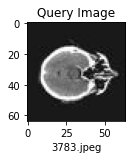

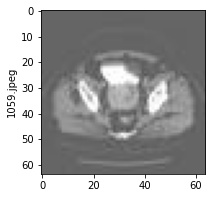

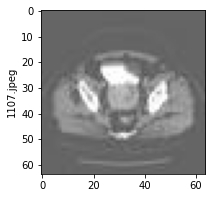

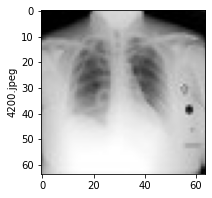

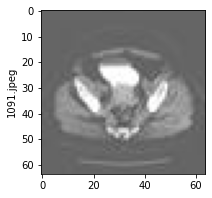

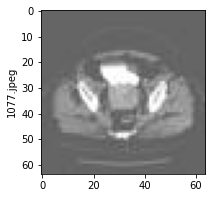

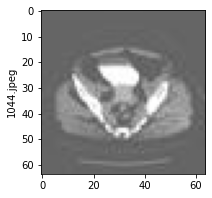

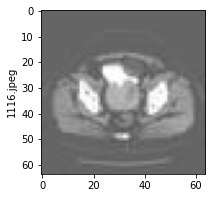

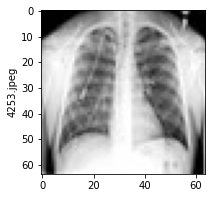

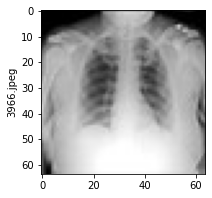

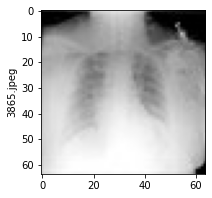

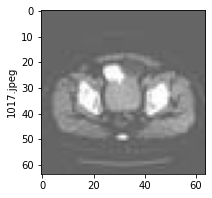

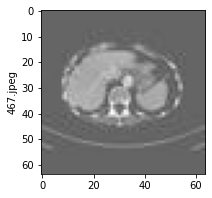

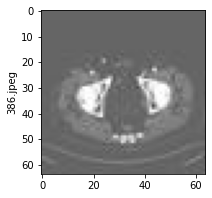

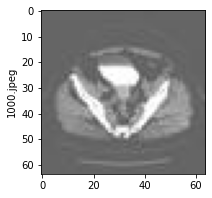

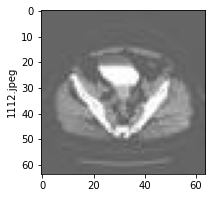

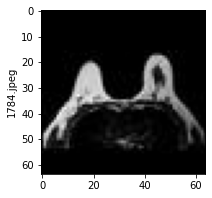

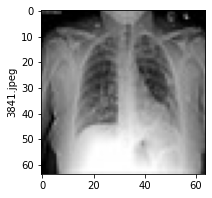

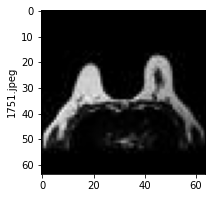

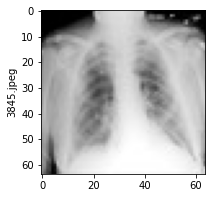

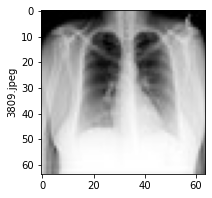

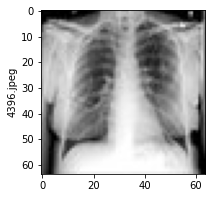

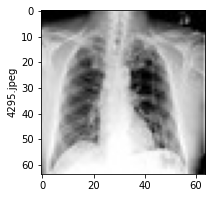

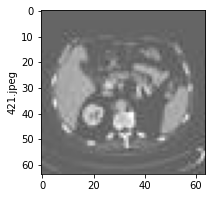

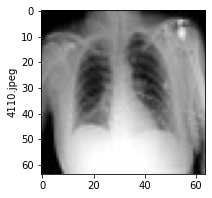

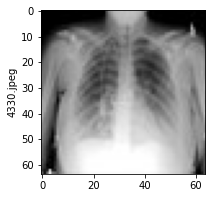

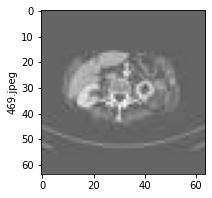

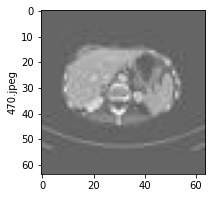

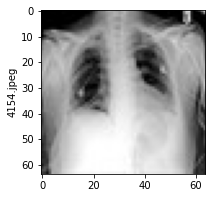

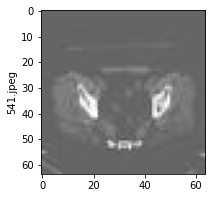

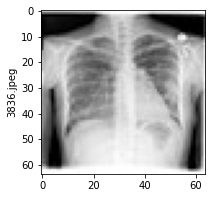

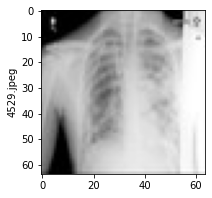

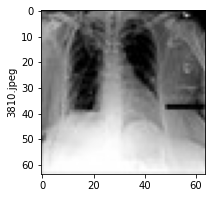

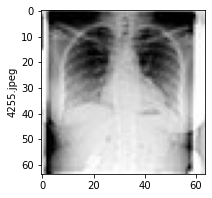

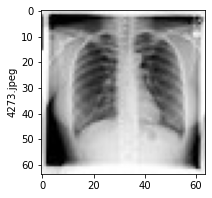

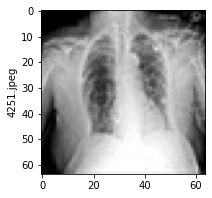

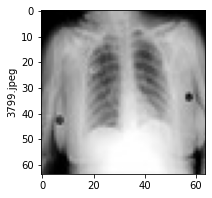

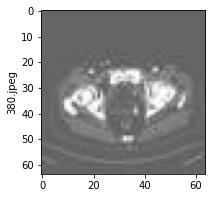

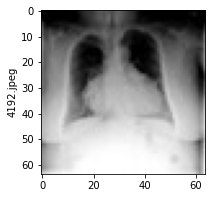

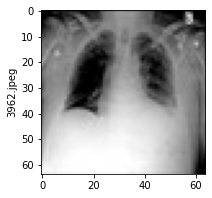

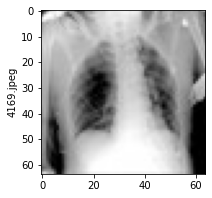

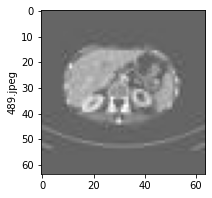

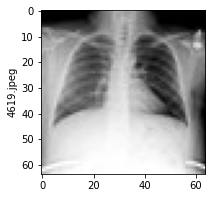

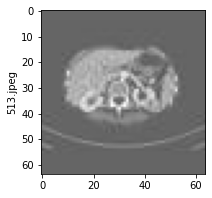

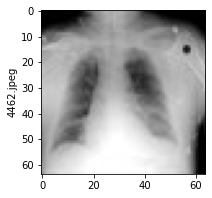

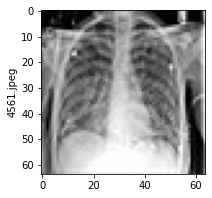

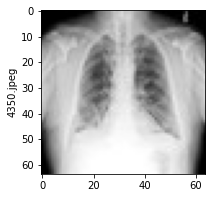

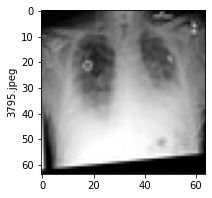

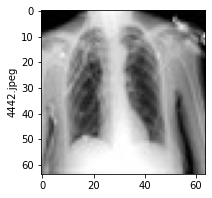

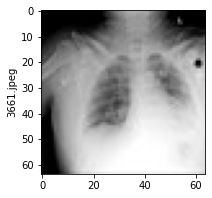

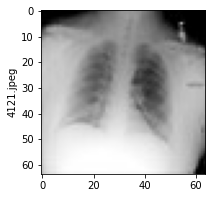

In [931]:
import matplotlib.pyplot as plt 
import os
import imageio
    
    #Extracting the feature vetor from the uploaded images and adding this vector to our database
#queryFn = "I:/Covid-19 Dataset/Covid19-dataset/test/All/0108.jpeg"
#queryFn = "I:Medical Dataset/CXR_Test-Hand_Test/000016.jpeg"
queryFn = "I:/Medical Dataset/10pFiveK/Test/Unlabeled/3783.jpeg"
img = cv2.imread(queryFn)
plt.subplot(231); plt.imshow(img); plt.title("Query Image"); plt.xlabel(os.path.basename(queryFn))
#features = index_one(str(UPLOAD_FOLDER + '/' + new_file_name) , params)
#dataset_path = "I:/Medical Dataset/10K/Train/"
params = {"theta": 4, "frequency": (0, 1, 0.5, 0.8), "sigma": (1, 3), "n_slice": 2}
#f = dataset_path
#names=[]
#print("preparing database files....")
#for file in os.listdir(f):
 #   fimg = f+file
  #  names.append(fimg)
  #  im=cv2.imread(fimg)
  #  imge=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  #  imge = cv2.resize(im,(64,64),3)
  #  feat = index(params)

    
#print("Database Ready!")

index(params)


#print("feats ->>> ",len(feats))
#features = index_one(queryFn , params)
features = index_one(queryFn , params)
#print("features (index_one) -> ",features)

paths = []
error=0
#myList={}
sam=[]
def myRes():
    #features = index_one(queryFn , params)
    #Comparing and sorting the uploaded image's features with the offline-calulcated images features
    if("1K" in queryFn):
        searcher = Search('./index.csv')
        results = searcher.search(features)
        #results = searcher.gaborSearch(features)
        RESULTS_LIST = list()
        RESULTS_LIST.clear()
    
        for (score, pathImage) in results:
            paths.append(str(pathImage))
            RESULTS_LIST.append(
            {"image": str(pathImage), "score": str(score)}
            )
    elif("5K" in queryFn):
        searcher = Search('./index5K.csv')
        results = searcher.search(features)
        # results = searcher.gaborSearch(features)
        RESULTS_LIST = list()
        RESULTS_LIST.clear()
        
        for (score, pathImage) in results:
            paths.append(str(pathImage))
            RESULTS_LIST.append(
            {"image": str(pathImage), "score": str(score)}
            )
    elif("10K" in queryFn):
        searcher = Search('./index10K.csv')
        results = searcher.search(features)
        # results = searcher.gaborSearch(features)
        RESULTS_LIST = list()
        RESULTS_LIST.clear()
        for (score, pathImage) in results:
            paths.append(str(pathImage))
            RESULTS_LIST.append(
            {"image": str(pathImage), "score": str(score)}
            )
    elif("10pFiveK" in queryFn):
        #print("Searching from 10.5K worth of feature vectors ")
        searcher = Search('./index15K.csv')
        results = searcher.search(features)
        # results = searcher.gaborSearch(features)
        RESULTS_LIST = list()
        RESULTS_LIST.clear()
        for (score, pathImage) in results:
            paths.append(str(pathImage))
            RESULTS_LIST.append(
            {"image": str(pathImage), "score": str(score)}
            )
    
    #print("RESULTS_LIST ->>>> ",RESULTS_LIST)#returning the search results#return jsonify(RESULTS_LIST)
    #print("result.score = ", RESULTS_LIST[0].get("score"))
    #da = cv2.imread(RESULTS_LIST[0].get("image"))
    #da2 = cv2.imread(RESULTS_LIST[1].get("image"))
    #da3 = cv2.imread(RESULTS_LIST[2].get("image"))
    #error = []
    #error=mse(img,da)
    #error[1]=da2
    #error[2]=da3

    #a=0
    #res = myRes()
    #print("res ->>> ",res)
    #pic=231
    #s=""
    #merror=0
    #for i in range(len(RESULTS_LIST)):
        #c +=1
        #pic += 1
        #das = cv2.imread(RESULTS_LIST[i].get("image"))
        #plt.imshow(da)
        #print("das --- ",das)
        
        #plt.subplot(pic);
        #merror = error
        #s = "\nMSE: %.5f" %merror
        #plt.title("Resulting Image"); plt.xlabel(os.path.basename(RESULTS_LIST[i].get("image"))+s);
        #plt.ylabel(RESULTS_LIST[i].get("score")); 
        
        
        #a += 1
    
    
    #tpos = 1
    
    #pre = precision(tpos,len(RESULTS_LIST))
    #print("Precision = %.5f" %pre)
    #print("Number of results Retrieved = ",len(RESULTS_LIST))
    #print("\n\n")
    #myList = RESULTS_LIST
    #print("b'4 clearing -> ",RESULTS_LIST)
    #RESULTS_LIST.popitem()
    opera(RESULTS_LIST,queryFn)
    #print("b'4 clearing__ -> ",RESULTS_LIST)
    RESULTS_LIST.clear()
    #print("clear results -> ",RESULTS_LIST)
    
    #return RESULTS_LIST
    
    



   
        
    



    


    
elapsed = time.time()-st
res = timeit.timeit(stmt='myRes()', globals=globals(), number=1)
print('CPU Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed)))
print('WALL Execution time:', time.strftime("%H:%M:%S", time.gmtime(res)))




In [932]:
#if __name__ == "__main__":
    #rt()
    #myRes()

In [933]:
print(retrieved_images)
my=[]
for t in range(len(retrieved_images)):
    my.append(cv2.imread(retrieved_images[t]))
    #my2= cv2.imread(retrieved_images[++t])
    vert = np.concatenate(my,axis=1)
    cv2.namedWindow('Target Image',cv2.WINDOW_AUTOSIZE)
    cv2.imshow('Target Image',vert)
    cv2.waitKey(5000)
cv2.waitKey(0)
cv2.destroyAllWindows()

['I:/Medical Dataset/10pFiveK/Train/1059.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1107.jpeg', 'I:/Medical Dataset/10pFiveK/Train/4200.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1091.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1077.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1044.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1116.jpeg', 'I:/Medical Dataset/10pFiveK/Train/4253.jpeg', 'I:/Medical Dataset/10pFiveK/Train/3966.jpeg', 'I:/Medical Dataset/10pFiveK/Train/3865.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1017.jpeg', 'I:/Medical Dataset/10pFiveK/Train/467.jpeg', 'I:/Medical Dataset/10pFiveK/Train/386.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1000.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1112.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1784.jpeg', 'I:/Medical Dataset/10pFiveK/Train/3841.jpeg', 'I:/Medical Dataset/10pFiveK/Train/1751.jpeg', 'I:/Medical Dataset/10pFiveK/Train/3845.jpeg', 'I:/Medical Dataset/10pFiveK/Train/3809.jpeg', 'I:/Medical Dataset/10pFiveK/Train/4396.jpeg', 'I:/Medical Da